<a href="https://colab.research.google.com/github/seanjhannon/pitch-prediction/blob/main/Decide_the_Next_Pitch_Reimplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install pybaseball --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 15.9 MB/s eta 0:00:00


In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pybaseball as pyb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Attention, Input
from tensorflow.keras.callbacks import ModelCheckpoint

# Data


## Loading

In [ ]:
# Function to get pitches for a specified pitcher from a specified date range
def get_pitches(
    fname: str,
    lname: str,
    start_date: str,
    end_date: str
):
  """
  Returns all pitches for a specified pitcher over a user-defined interval.

  Params
    fname (string): Pitcher's first name.
    lname (string): Pitcher's last name.
    start_date (string): Date to start collecitng pitches, must be in format YYYY-MM-DD.
    end_date (string): Date to stop collecitng pitches, must be in format YYYY-MM-DD.

  Returns
    pitches (pandas DataFrame): DataFrame of statcast data for all pitches in the player's career.
  """
  # Search for player 'lookup' - returns their metadata
  player_lookup = pyb.playerid_lookup(lname, fname, fuzzy=False)

  # Check for incorrect name input
  if len(player_lookup) != 1:
    print(f'Player Lookup returned {len(player_lookup)} results. Please double-check inputs and try again.')
    return None

  # Collect the player's lmbam_id and start and end of his career
  player_id = player_lookup['key_mlbam'][0]
  pitches = pyb.statcast_pitcher(start_dt=start_date,
                             end_dt=end_date,
                             player_id=player_id)
  # Notify user in case where no pitches are found
  if len(pitches) == 0:
    print(f'No pitches found for {fname} {lname}')

  return pitches

In [ ]:
# Record useful dates for querying pitches - cut off preseason and postseason
start_2015_season = '2015-04-05'
end_2018_season = '2018-10-01'
start_2021_season = '2021-04-01'
end_2021_season = '2021-10-03'

# Collect pitching data separately
player_fname = 'wade'
player_lname = 'miley'

data_15_to_18 = get_pitches(fname=player_fname,
                            lname=player_lname,
                            start_date=start_2015_season,
                            end_date=end_2018_season
                            )

data_21 = get_pitches(fname=player_fname,
                      lname=player_lname,
                      start_date=start_2021_season,
                      end_date=end_2021_season
                      )

full_data = pd.concat([data_15_to_18, data_21], axis=0)
full_data.shape

Gathering player lookup table. This may take a moment.
Gathering Player Data
Gathering Player Data


(13424, 92)

In [ ]:
# Define acceptable pitch types
valid_pitch_dict = {
    'FF': 'Four-Seam Fastball', 'FT': 'Two-Seam Fastball',
    'CH': 'Change-up', 'CU': 'Curveball',
    'FC': 'Cutter', 'EP': 'Eephus',
    'FO': 'Forkball', 'KC': 'Knuckle Curve',
    'KN': 'Knuckleball', 'SC': 'Screwball',
    'SI': 'Sinker', 'SL': 'Slider',
    'FS': 'Splitter',
}

filtered_pitches_pitch_type = full_data[
    full_data['pitch_type'].str.contains(
        '|'.join(list(valid_pitch_dict.keys())), na=False)
    ]

In [ ]:
filtered_pitches_pitch_type.shape

(13182, 92)

In [ ]:
# Consider only regular season
filtered_pitches_game_type = filtered_pitches_pitch_type[filtered_pitches_pitch_type['game_type']=='R']
# Store the pitcher's repertoire
repertoire_abb = filtered_pitches_game_type['pitch_type'].unique()
repertoire_full = filtered_pitches_game_type['pitch_name'].unique()

In [ ]:
top_pitch = filtered_pitches_game_type['pitch_type'].value_counts().head(1)
top_pitch_name = valid_pitch_dict[top_pitch.index[0]]
top_pitch_freq = int(
    (top_pitch.values[0] / len(filtered_pitches_game_type)) * 100)
print(f'{player_fname} {player_lname} throws {top_pitch_name} {top_pitch_freq}% of the time')

wade miley throws Four-Seam Fastball 27% of the time


## Feature Creation

In [ ]:
data = filtered_pitches_game_type # Result for previous step

In [ ]:
def score_diff(row):
  # Exploit the fact that the away team bats first
  if row['inning_topbot'] == 'Top':
    score_diff = row['home_score'] - row['away_score']
  else:
    score_diff = row['away_score'] - row['home_score']
  return score_diff

In [ ]:
# Create a unique plate-appearance ID from game id, batter, at_bat_number
id_cols = [['game_pk', 'batter', 'at_bat_number']]
data.loc[:,'plate_app_id'] =  data['game_pk'].astype(str) + data['batter'].astype(str) + data['at_bat_number'].astype(str)

<ipython-input-12-db796c75fa76>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'plate_app_id'] =  data['game_pk'].astype(str) + data['batter'].astype(str) + data['at_bat_number'].astype(str)


In [ ]:
data = data.sort_values(['game_date',
                         'game_pk', # Handle double headers
                         'plate_app_id',
                         'pitch_number'], ascending=True)

# Create previous pitch column
data.loc[:,'previous_pitch'] = data['pitch_type'].shift(1)
data.loc[data['pitch_number'] == 1, 'previous_pitch'] = None

# Create previous zone column
data.loc[:,'previous_zone'] = data['zone'].shift(1)
data.loc[data['pitch_number'] == 1, 'previous_zone'] = None

# Encode runners on base
on_base_cols = [
    'on_3b', 'on_2b', 'on_1b',
]
for col in on_base_cols:
  data.loc[:,col] = data[col].fillna(0)
  data.loc[data[col] != 0, col] = 1

# Create score difference
data.loc[:,'score_diff'] = data.apply(score_diff, axis=1)
data

selected_features = [
    'plate_app_id',
    'previous_pitch',
    'previous_zone',
    'pitch_number',
    'inning',
    'on_3b', 'on_2b', 'on_1b',
    'score_diff',
    'balls',
    'outs_when_up',
    'pitch_type'
]

selected_cols = data[selected_features]


In [ ]:
selected_cols['pitch_type'].value_counts()

pitch_type
FF    3500
CH    2356
FC    2171
SI    2038
SL    1546
CU    1242
Name: count, dtype: int64

In [ ]:
selected_cols

,plate_app_id,previous_pitch,previous_zone,pitch_number,inning,on_3b,on_2b,on_1b,score_diff,balls,outs_when_up,pitch_type
10784,41369612134729,None,NaN,1,4,0.0,1.0,0.0,1,0,1,FF
10783,41369612134729,FF,7.0,2,4,0.0,1.0,0.0,1,0,1,SL
10782,41369612134729,SL,4.0,3,4,0.0,1.0,0.0,1,0,1,FF
10781,41369612134729,FF,13.0,4,4,0.0,1.0,0.0,1,1,1,FF
10748,41369612134750,None,NaN,1,6,1.0,0.0,1.0,3,0,1,SI
...,...,...,...,...,...,...,...,...,...,...,...,...
43,6324326692579,CH,14.0,4,2,0.0,0.0,0.0,0,2,1,CH
42,6324326692579,CH,9.0,5,2,0.0,0.0,0.0,0,2,1,FF
41,6324326692579,FF,5.0,6,2,0.0,0.0,0.0,0,2,1,FF
40,6324326692579,FF,7.0,7,2,0.0,0.0,0.0,0,2,1,FC


##OHE

In [ ]:
cat_cols = [
    'previous_pitch',
    'previous_zone',
    'inning',
    'balls',
    'pitch_type'
]

encoded_df = pd.get_dummies(selected_cols, columns=cat_cols, dtype=int)

In [ ]:
# data = encoded_df.astype(np.float64)
# test_split_ratio = 0.8
# val_split_ratio = 0.9

# train_val_size = int(len(data) * test_split_ratio)
# train_val_data, test_data = data[:train_val_size], data[train_val_size:]


# train_size = int(len(train_val_data) * val_split_ratio)
# train_data, val_data = train_val_data[:train_size], train_val_data[train_size:]

In [ ]:
# data.shape, train_val_data.shape, test_data.shape,

In [ ]:
# len(train_val_data) *

In [ ]:
# train_data.shape, val_data.shape, test_data.shape

# Sequencing

In [ ]:
class Sequencer:

    def __init__(self,
                 data: pd.core.frame.DataFrame,
                 max_length: int,
                 n_features: int,
                 n_pitch_types: int) -> None:

        self.data = data
        self.max_length = max_length
        self.n_features = n_features
        self.n_pitch_types = n_pitch_types


    def _make_mappings(self, group):
        data_arr = group.values
        dict_keys = [i for i in range(1, len(group)+ 1)] #1-indexing the feature vectors lets us reserve 0 for padding
        features = data_arr[:,1 : -self.n_pitch_types]
        labels = data_arr[:, -self.n_pitch_types:]
        index_to_pitch = dict(zip(dict_keys, features))
        index_to_pitch[0] = np.zeros(features.shape[1], dtype='int64')
        index_to_label = dict(zip(dict_keys, labels))
        return index_to_pitch, index_to_label


    def _ascending_subsequences(self, increasing_list: list):
        """
        Break a list of increasing numbers into all possible increasing subsequences, including one-numbered subsequences.
        For a list of len == n, n(n+1)/2 sublists will be generated.
        Args
            increasing_list: A list of inceasing numbers. Each number is the index of a feature vector.
        Returns
            subsequences: A list of the n(n+1)/2 sublists.
        """
        subsequences = []
        n = len(increasing_list)
        for i in range(n):
            for j in range(i+1, n+1):
                subsequences.append(increasing_list[i:j])
        return subsequences


    def _build_sequences(self, subsequences):
        """
        Convert nested list of subsequences into a (n, m) matrix where m is the desired length (number of timesteps) allowed per sequence and n is determined dynamically by that restriction.
        Subsequences shorter than the desired length are padded with zeroes; longer subsequences are broken up and padded accordingly.
        Args
            subsequences: output of ascending_subsequences; a list of all possible subsequences of the indices of our feature vectors.
        Returns
            processed_sublists: (n, m) matrix representing the sequences we have computed for our pitch feature vectors.
        """

        length = self.max_length
        processed_sublists = []

        for sublist in subsequences:
            sublist_length = len(sublist)
            if sublist_length < length: # If too short
                sublist.extend([0] * (length - sublist_length))
                processed_sublists.append(sublist)
            else:
                num_sublists = (sublist_length + length - 1) // length
                pad_length = num_sublists * length - sublist_length
                sublist = np.pad(sublist, (0, pad_length), mode='constant', constant_values=0)
                processed_sublists.extend(np.split(sublist, num_sublists))
        return np.array(processed_sublists)

    def _populate_vectors(self, group):
        """
        After building the skeleton of our sequences using scalars for legibility and simplicity, use the feature vector mappings to populate the full 3D feature and label matrices.
        This function operates on one 'group' at a time, where each group is a unique atbat from a pitcher's history.
        This function is mapped onto our 2D DataFrame of pitches in a pandas groupby.
        Args
            group: A group resulting from a pandas groupby operation. Each group is a unique plate appearance.
        Returns
            all_features: (s, t, f) numpy array where s = the number of samples, t = the number of time steps per sample, and f = the number of features of every sample

        """
        group = group.sort_values('pitch_number', ascending=True)
        index_to_pitch, index_to_label = self._make_mappings(group)

        subsequences = self._ascending_subsequences(list(index_to_label.keys()))

        index_to_label[0] = np.zeros(self.n_pitch_types, dtype='int64') # add this now to prevent messing up the key length

        processed_sublists = self._build_sequences(subsequences)
        #print(processed_sublists)
        all_features = np.array([[index_to_pitch[i] for i in sublist] for sublist in processed_sublists])

        #all_labels = np.array([[index_to_label[i] for i in sublist] for sublist in processed_sublists]) # no worky

        all_labels = np.array(
            [index_to_label[max(sublist)] for sublist in processed_sublists]
        )


        return all_features, all_labels



    def make_sequences(self):

        data = self.data.astype(np.float64)

        test_split_ratio = 0.8
        val_split_ratio = 0.9

        train_val_size = int(len(data) * test_split_ratio)
        train_val_data, test_data = data[:train_val_size], data[train_val_size:]


        train_size = int(len(train_val_data) * val_split_ratio)
        train_data, val_data = train_val_data[:train_size], train_val_data[train_size:]

        train_sequences = train_data.groupby('plate_app_id').apply(self._populate_vectors)
        X_train = np.concatenate([result[0] for result in train_sequences])
        y_train = np.concatenate([result[1] for result in train_sequences])

        val_sequences = val_data.groupby('plate_app_id').apply(self._populate_vectors)
        X_val = np.concatenate([result[0] for result in val_sequences])
        y_val = np.concatenate([result[1] for result in val_sequences])

        test_sequences = test_data.groupby('plate_app_id').apply(self._populate_vectors)
        X_test = np.concatenate([result[0] for result in test_sequences])
        y_test = np.concatenate([result[1] for result in test_sequences])

        return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
repertoire_size = len(repertoire_abb)
n_features = encoded_df.shape[1] - repertoire_size

seq = Sequencer(data=encoded_df,
                max_length=6,
                n_features=n_features,
                n_pitch_types=repertoire_size
                )


X_train, X_val, X_test, y_train, y_val, y_test = seq.make_sequences()

dict_keys([1, 2, 3, 4, 0])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 0])
dict_keys([1, 0])
dict_keys([1, 2, 3, 4, 5, 6, 0])
dict_keys([1, 2, 3, 4, 5, 6, 7, 0])
dict_keys([1, 2, 0])
dict_keys([1, 2, 3, 4, 5, 0])
dict_keys([1, 2, 3, 4, 5, 6, 7, 0])
dict_keys([1, 2, 3, 4, 5, 6, 0])
dict_keys([1, 2, 3, 0])
dict_keys([1, 2, 0])
dict_keys([1, 2, 3, 4, 5, 6, 0])
dict_keys([1, 2, 3, 4, 5, 0])
dict_keys([1, 2, 3, 4, 5, 0])
dict_keys([1, 2, 0])
dict_keys([1, 2, 3, 4, 5, 6, 0])
dict_keys([1, 2, 0])
dict_keys([1, 2, 3, 4, 5, 0])
dict_keys([1, 2, 3, 4, 5, 0])
dict_keys([1, 2, 3, 4, 5, 0])
dict_keys([1, 2, 3, 4, 5, 0])
dict_keys([1, 2, 3, 4, 5, 0])
dict_keys([1, 0])
dict_keys([1, 2, 3, 0])
dict_keys([1, 2, 3, 4, 5, 0])
dict_keys([1, 2, 3, 4, 5, 0])
dict_keys([1, 2, 3, 4, 5, 0])
dict_keys([1, 2, 3, 4, 0])
dict_keys([1, 2, 3, 4, 5, 6, 0])
dict_keys([1, 0])
dict_keys([1, 2, 3, 4, 0])
dict_keys([1, 2, 0])
dict_keys([1, 2, 3, 4, 5, 0])
dict_keys([1, 0])
dict_keys([1, 2, 3, 0])
dict_keys([1, 2, 3, 4, 0])
dict_ke

In [ ]:
encoded_df

,plate_app_id,pitch_number,on_3b,on_2b,on_1b,score_diff,outs_when_up,previous_pitch_CH,previous_pitch_CU,previous_pitch_FC,...,balls_0,balls_1,balls_2,balls_3,pitch_type_CH,pitch_type_CU,pitch_type_FC,pitch_type_FF,pitch_type_SI,pitch_type_SL
10784,41369612134729,1,0.0,1.0,0.0,1,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
10783,41369612134729,2,0.0,1.0,0.0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
10782,41369612134729,3,0.0,1.0,0.0,1,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
10781,41369612134729,4,0.0,1.0,0.0,1,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
10748,41369612134750,1,1.0,0.0,1.0,3,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,6324326692579,4,0.0,0.0,0.0,0,1,1,0,0,...,0,0,1,0,1,0,0,0,0,0
42,6324326692579,5,0.0,0.0,0.0,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
41,6324326692579,6,0.0,0.0,0.0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
40,6324326692579,7,0.0,0.0,0.0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0


## Train-Test Split

# Neural Network Implementation

In [ ]:
input_shape = X_train.shape[1:]
num_classes = repertoire_size

In [ ]:
from tensorflow.keras import layers, models
# Single layer LSTM with 256 units
model_1 = Sequential([
    LSTM(units=128, input_shape=input_shape),
    Dense(units=num_classes, activation='softmax')
])


# Stacked LSTM
model_2 = Sequential([
    LSTM(units=256, input_shape=input_shape, return_sequences=True),
    LSTM(units=256),
    Dense(units=num_classes, activation='softmax')
])

# Define LSTM model with attention mechanism
def attention_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    lstm1 = LSTM(256, return_sequences=True)(inputs)
    lstm2 = LSTM(256, return_sequences=True)(lstm1)
    attention = Attention()([lstm2, lstm2])
    context_vector = tf.reduce_sum(attention, axis=1)
    output = Dense(num_classes, activation='softmax')(context_vector)
    model = models.Model(inputs=inputs, outputs=output)
    return model

model_3 =attention_lstm_model(input_shape, num_classes)

In [ ]:
# Model testing
models = [model_1, model_2, model_3]
model = models[0]

# Display model summary
model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'],
              )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               85504     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 86278 (337.02 KB)
Trainable params: 86278 (337.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
checkpoint_filepath = './'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(X_train, y_train,
          batch_size=64,
          epochs = 10,
          validation_data = (X_val, y_val),
                    callbacks = [model_checkpoint_callback]
          )

Epoch 1/10
431/431 [==============================] - 16s 29ms/step - loss: 1.5898 - accuracy: 0.3411 - val_loss: 1.9895 - val_accuracy: 0.2720
Epoch 2/10
431/431 [==============================] - 10s 24ms/step - loss: 1.5264 - accuracy: 0.3659 - val_loss: 1.9808 - val_accuracy: 0.2740
Epoch 3/10
431/431 [==============================] - 11s 25ms/step - loss: 1.5075 - accuracy: 0.3740 - val_loss: 1.8723 - val_accuracy: 0.3002
Epoch 4/10
431/431 [==============================] - 8s 18ms/step - loss: 1.4884 - accuracy: 0.3837 - val_loss: 1.9934 - val_accuracy: 0.2489
Epoch 5/10
431/431 [==============================] - 11s 26ms/step - loss: 1.4656 - accuracy: 0.3890 - val_loss: 1.9271 - val_accuracy: 0.3126
Epoch 6/10
431/431 [==============================] - 7s 15ms/step - loss: 1.4390 - accuracy: 0.4002 - val_loss: 1.9902 - val_accuracy: 0.2995
Epoch 7/10
431/431 [==============================] - 8s 18ms/step - loss: 1.4064 - accuracy: 0.4167 - val_loss: 1.9867 - val_accuracy: 0.

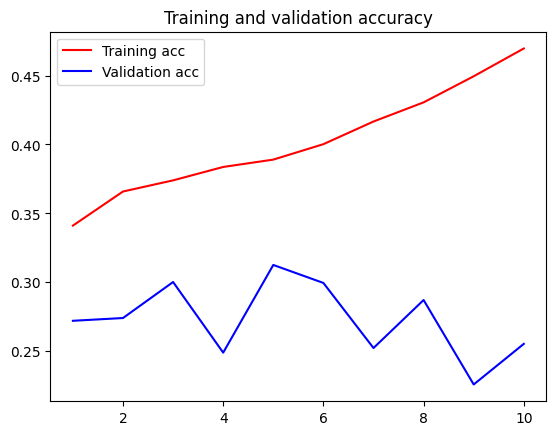

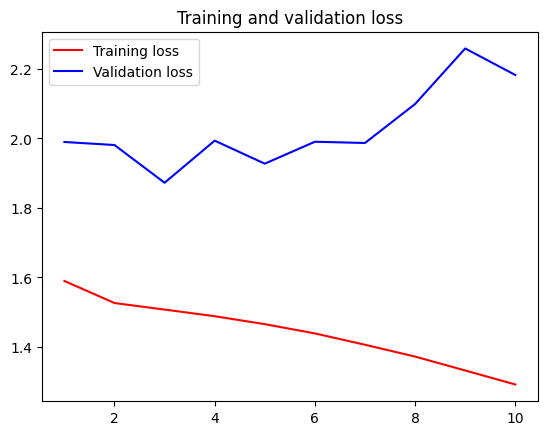

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
best_model = tf.keras.models.load_model(checkpoint_filepath)
preds = best_model.predict(X_test)

235/235 [==============================] - 5s 11ms/step


Accuracy: 0.3436792327161316


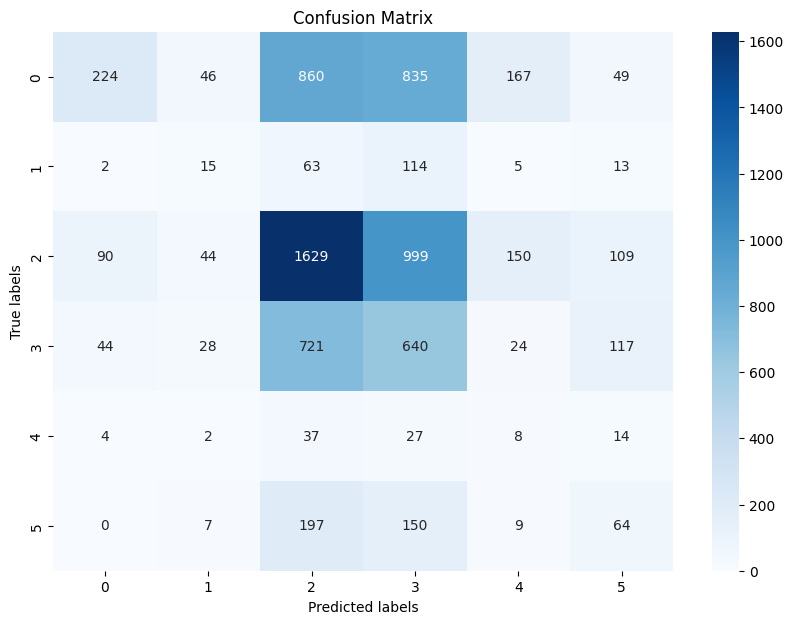

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.10      0.18      2181
           1       0.11      0.07      0.08       212
           2       0.46      0.54      0.50      3021
           3       0.23      0.41      0.29      1574
           4       0.02      0.09      0.04        92
           5       0.17      0.15      0.16       427

    accuracy                           0.34      7507
   macro avg       0.27      0.23      0.21      7507
weighted avg       0.43      0.34      0.33      7507



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Assuming you have your true labels in y_true and predicted labels in y_pred
# You should replace these with your actual labels

y_true = y_true_labels = np.argmax(y_test, axis=1)

y_pred = np.argmax(preds, axis=1)


# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert confusion matrix to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=range(len(cm)), columns=range(len(cm)))



# Plot confusion matrix heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


In [ ]:
repertoire_abb

array(['SI', 'FC', 'CU', 'CH', 'FF', 'SL'], dtype=object)

In [ ]:
selected_cols['pitch_type'].unique()

array(['FF', 'SL', 'SI', 'CH', 'CU', 'FC'], dtype=object)